In [1]:
using LinearAlgebra,Statistics,SparseArrays,Distributions,Trapz,ApproxFun,SpecialFunctions,RandomMatrices,Plots,LaTeXStrings,TypedTables
using StatsBase,FFTW,DifferentialEquations,ForwardDiff

Let's first initialize some essential functions before delving into the adaptive time-stepping methods.

In [2]:
function time_gen(x1,x2,Δx)
    xs=x1:Δx:x2 |> Array
    if abs(xs[end])<abs(x2)
        xs=x1:Δx:(x2+Δx) |> Array
    end
    return xs
end

time_gen (generic function with 1 method)

In [3]:
function initial_gen(β;method,x0,Δx_f,Δx_s,M_f,M_s,l)
    Φ = x -> erf.(x/sqrt(2))/2 + 0.5
    dϕ = x -> exp.(-x^2/2)*1/sqrt(2pi)
    g = (x0,β,t) -> Φ( (x0 - cot(t).^2)./sqrt.(4/β * cot.(t)) )
    h0 = (x0,β,t) -> t < pi/2 ? g(x0,β,t) : 1.0
    chain = (x0,β,t) -> (x0 + 3*cot.(t).^2).*csc.(t).*sec.(t)./sqrt.(16/β * cot.(t))
    dg = (x0,β,t) -> t ≈ 0.0 ? 0.0 : dϕ((x0 - cot(t).^2)./sqrt(4/β * cot.(t))).*chain(x0,β,t)
    dh0 = (x0,β,t) -> t < pi/2 ? dg(x0,β,t) : 0.0
    mfft = x -> fftshift(fft(x))/length(x)

    if method=="finite"
        mgrid=(n,L) -> L*(1:n)/n
        θ=mgrid(M_f,pi)
        h=(1/M_f)*pi
        c0=map(t -> h0(x0,β,t),θ)
        c1=map(t -> h0(x0-Δx_f,β,t),θ)
        c2=map(t -> h0(x0-2*Δx_f,β,t),θ)
        c3=map(t -> h0(x0-3*Δx_f,β,t),θ)
        c4=map(t -> h0(x0-4*Δx_f,β,t),θ)
        c5=map(t -> h0(x0-5*Δx_f,β,t),θ)
    elseif method=="spectral"
        mgrid = (n,L) -> 2*L*(0:n-1)/n
        θ=mgrid(M_s,l*pi)
        h=(1/M_s)*2*l*pi
        c0=map(t -> dh0(x0,β,t),θ)|>mfft
        c1=map(t -> dh0(x0-Δx_s,β,t),θ)|>mfft
        c2=map(t -> dh0(x0-2*Δx_s,β,t),θ)|>mfft
        c3=map(t -> dh0(x0-3*Δx_s,β,t),θ)|>mfft
        c4=map(t -> dh0(x0-4*Δx_s,β,t),θ)|>mfft
        c5=map(t -> dh0(x0-5*Δx_s,β,t),θ)|>mfft
    end
    return c0,c1,c2,c3,c4,c5,h,θ
end

initial_gen (generic function with 1 method)

In [4]:
function matrix_gen(β;method,M_f,M_s,h,θ,l)
    diffvec = (L,m,j) -> ((-floor(m/2):1:floor((m-1)/2))*(1im*pi/L)).^j
    function 𝒟(L,m,j)
        spdiagm(diffvec(L,m,j))
    end
    if method=="finite"
        T=spdiagm(0=>fill(-2.0,M_f),1=>fill(1.0,M_f-1),-1=>fill(1.0,M_f-1))
        tt=(-2*(sin.(θ)).^4)/(β*(h^2))
        T=spdiagm(0=>vec(tt))*T
        um1=ones(Int64,M_f-2,1);um1=vcat(um1,4);ud=zeros(Int64,M_f-1,1);ud=vcat(ud,-3);um2=zeros(Int64,M_f-3,1);um2=vcat(um2,-1)
        U=spdiagm(0=>vec(ud),1=>fill(-1.0,M_f-1),-1=>vec(um1),-2=>vec(um2))
        tt2=(1/(2*h))*((2*sin.(2*θ)/β).*(sin.(θ)).^2-(cos.(θ)).^2)
        A=T+spdiagm(0=>vec(tt2))*U
        uu=(1/(2*h))*(sin.(θ)).^2
        B=spdiagm(0=>vec(uu))*U
    elseif method=="spectral"
        mme = spdiagm( l => fill(1.0,M_s-l), l-M_s => fill(1.0,l))
        me = spdiagm( -l => fill(1.0,M_s-l), M_s-l => fill(1.0,l))
        ms = (me - mme)/2im;
        ms2 = (me^2 - mme^2)/2im;
        mc = (me + mme)/2;
        mc2 = (me^2 + mme^2)/2;
        DD = 𝒟(l*pi,M_s,1) |> sparse;
        A = (-2/β)*ms^4*DD^2 - (8/β)*ms^3*mc*DD - (2/β)*ms2*ms^2*DD + mc^2*DD - (4/β)*(ms*mc*ms2 + ms^2*mc2) - 2*mc*ms;
        B = -ms^2*DD - 2*ms*mc
    end
    return A,B
end

matrix_gen (generic function with 1 method)

In [5]:
function Fourier_interp(xs,cheb,TW_cdf,TW_pdf)  
    ϕ = x -> (erf.(x) .+ 1.0)/2
    j=PeriodicSegment(xs[end],xs[1])
    S=Laurent(j)
    final_pdf=TW_pdf[2:end] |> reverse
    final_cdf=TW_cdf[2:end] |> reverse
    xx=xs[2:end] |> reverse
    f_pdf=Fun(S,ApproxFun.transform(S,final_pdf))
    f_cdf=Fun(S,ApproxFun.transform(S,final_cdf-ϕ(xx)))
    S2=xs[end]..xs[1] |> Chebyshev
    pdf_cheb=Fun(f_pdf,S2,cheb) |> real
    cdf_cheb=Fun(f_cdf,S2,cheb) + Fun(ϕ,S2) |> real
    return cdf_cheb,pdf_cheb
end

Fourier_interp (generic function with 1 method)

We want to solve the following ODE:

$$
\frac {d \pmb{a}_{M}(x)}{d x}=\left(A+xB\right)\pmb{a}_{M}(x),\text{ }\pmb{a}_{M}(x)=\begin{bmatrix}
a_{-M}(x)\\
\vdots\\
a_{M}(x) \end{bmatrix}.
$$

In [6]:
function TWODE(da,a,p,x)
    A, B = p
    da .= (A.+x.*B)*a
end

TWODE (generic function with 1 method)

Setting up the parameters.

In [7]:
TW2 = TracyWidom;
β = 2;
x0 = 13.0/(sqrt(β));
xN = -10;
Δx_s=-0.001;
xs = time_gen(x0,xN,Δx_s);
xl=length(xs);
Δx_f=-0.001;
M_s = 8000;
l=10;
c0,c1,c2,c3,c4,c5,h,θ = initial_gen(β;method="spectral",x0 = x0,Δx_f=Δx_f,Δx_s=Δx_s,M_f=Int(floor(-1/(Δx_f))),M_s=M_s,l=l);
A,B = matrix_gen(β;method="spectral",M_f = Int(floor(-1/(Δx_f))),M_s = M_s,h=h, θ=θ,l=l);
Δx=xs[2]-xs[1];
N=-floor(M_s/2):1:floor((M_s-1)/2);
integ=zeros(ComplexF64,length(N));
for j=1:length(N)
    if N[j]==0
        integ[j]=pi
    else
        integ[j]=l/(im*N[j])*(exp(im*N[j]*pi/l)-1)
    end
end

xspan = (x0,xN);
p = [A, B];
prob = ODEProblem(TWODE, c0, xspan, p);
ForwardDiff.can_dual(::Type{ComplexF64}) = true;
Base.eps(::Type{ComplexF64}) = eps(Float64);

With $\texttt{TRBDF2}$ from $\texttt{DifferentialEquations.jl}$, we have

In [8]:
function TW_22(β;prob=prob,Δx_s=Δx_s)
    
    sol = solve(prob, TRBDF2(autodiff=false),dense = false, saveat=Δx_s)
    ll = length(sol.u)
    TW_cdf=zeros(ll,1)
    TW_pdf=zeros(ll,1)
    TW_cdf[1]=1
    TW_pdf[1]=0
    for i = 1:ll-1
        TW_cdf[i+1] = sum(sol.u[i+1].*integ)|> real
        c0_pdf=(A+sol.t[i+1]*B)*sol.u[i+1]
        TW_pdf[i+1] = sum(c0_pdf.*integ)|> real
    end
    cdf_cheb, pdf_cheb = Fourier_interp(sol.t,10^3,TW_cdf,TW_pdf)
    return cdf_cheb, pdf_cheb
    
end

TW_22 (generic function with 1 method)

In [9]:
@time cdf_cheb, pdf_cheb = TW_22(β);

8183.558535 seconds (49.87 M allocations: 183.267 GiB, 0.21% gc time, 0.24% compilation time)


### Error across the domain

In [10]:
function err_cdf22(D1,D2)
    er_cdf=Plots.plot()
    err2=zeros(length(D2),1)
    for i=1:length(D2)
        temp=D2[i]
        err2[i]=abs(cdf_cheb(temp)-cdf(TW2,temp;beta=2,num_points=300))
    end
    for i=1:length(D2)
        if err2[i]<10^(-16)
            err2[i]=10^(-16)
        end
    end
    er_cdf=Plots.plot!(D2,err2,lw=5,label=L"$\beta=2$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
        yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],xticks=D1[end]:2:D1[1],legend=:topright)
    return er_cdf
end

err_cdf22 (generic function with 1 method)

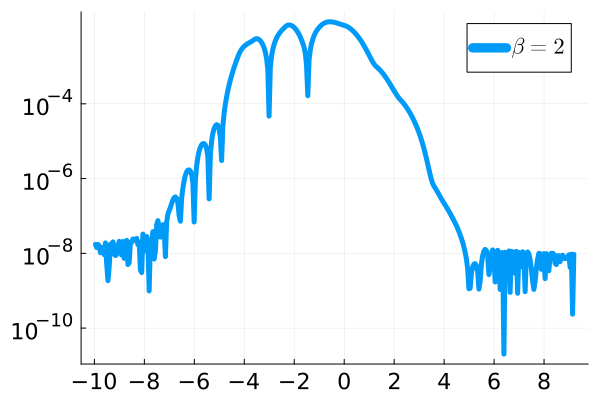

In [11]:
D1=(13/sqrt(1)):-0.05:-10;
D2=(13/sqrt(2)):-0.05:-10;
er_cdf=err_cdf22(D1,D2)

With $\texttt{SDIRK2}$ from $\texttt{DifferentialEquations.jl}$, we have

In [12]:
function TW_sdirk2(β;prob=prob,Δx_s=Δx_s)
    
    sol = solve(prob, SDIRK2(autodiff=false),dense = false,saveat=Δx_s)
    ll = length(sol.u)
    TW_cdf=zeros(ll,1)
    TW_pdf=zeros(ll,1)
    TW_cdf[1]=1
    TW_pdf[1]=0
    for i = 1:ll-1
        TW_cdf[i+1] = sum(sol.u[i+1].*integ)|> real
        c0_pdf=(A+sol.t[i+1]*B)*sol.u[i+1]
        TW_pdf[i+1] = sum(c0_pdf.*integ)|> real
    end
    cdf_cheb, pdf_cheb = Fourier_interp(sol.t,10^3,TW_cdf,TW_pdf)
    return cdf_cheb, pdf_cheb
    
end

TW_sdirk2 (generic function with 1 method)

In [13]:
@time cdf_cheb2, pdf_cheb2 = TW_sdirk2(β);

5513.796670 seconds (5.96 M allocations: 169.789 GiB, 0.32% gc time, 0.04% compilation time)


### Error across the domain

In [14]:
function err_cdfsd2(D1,D2)
    er_cdf=Plots.plot()
    err2=zeros(length(D2),1)
    for i=1:length(D2)
        temp=D2[i]
        err2[i]=abs(cdf_cheb2(temp)-cdf(TW2,temp;beta=2,num_points=300))
    end
    for i=1:length(D2)
        if err2[i]<10^(-16)
            err2[i]=10^(-16)
        end
    end
    er_cdf=Plots.plot!(D2,err2,lw=5,label=L"$\beta=2$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
        yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],xticks=D1[end]:2:D1[1],legend=:topright)
    return er_cdf
end

err_cdfsd2 (generic function with 1 method)

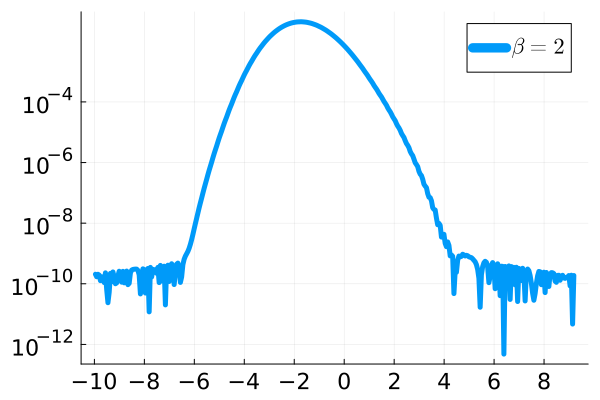

In [15]:
er_cdfsd2=err_cdfsd2(D1,D2)

With $\texttt{Rodas4}$ from $\texttt{DifferentialEquations.jl}$, we have

In [16]:
function TW_Rodas4(β;prob=prob,Δx_s=Δx_s)
    
    sol = solve(prob, Rodas4(autodiff=false),dense = false)
    ll = length(sol.u)
    TW_cdf=zeros(ll,1)
    TW_pdf=zeros(ll,1)
    TW_cdf[1]=1
    TW_pdf[1]=0
    for i = 1:ll-1
        TW_cdf[i+1] = sum(sol.u[i+1].*integ)|> real
        c0_pdf=(A+sol.t[i+1]*B)*sol.u[i+1]
        TW_pdf[i+1] = sum(c0_pdf.*integ)|> real
    end
    cdf_cheb,pdf_cheb = Fourier_interp(sol.t,10^3,TW_cdf,TW_pdf)
    return cdf_cheb, pdf_cheb
    
end

TW_Rodas4 (generic function with 1 method)

In [17]:
@time cdf_cheb4, pdf_cheb4 = TW_Rodas4(β);

13600.923046 seconds (7.42 M allocations: 659.709 GiB, 0.29% gc time, 0.02% compilation time)


### Error across the domain

In [18]:
function err_cdfro4(D1,D2)
    er_cdf=Plots.plot()
    err2=zeros(length(D2),1)
    for i=1:length(D2)
        temp=D2[i]
        err2[i]=abs(cdf_cheb4(temp)-cdf(TW2,temp;beta=2,num_points=300))
    end
    for i=1:length(D2)
        if err2[i]<10^(-16)
            err2[i]=10^(-16)
        end
    end
    er_cdf=Plots.plot!(D2,err2,lw=5,label=L"$\beta=2$",yaxis=:log10,xtickfontsize=15,ytickfontsize=15,legendfontsize=15,
        yticks=[10^(-16),10^(-14),10^(-12),10^(-10),10^(-8),10^(-6),10^(-4)],xticks=D1[end]:2:D1[1],legend=:topright)
    return er_cdf
end

err_cdfro4 (generic function with 1 method)

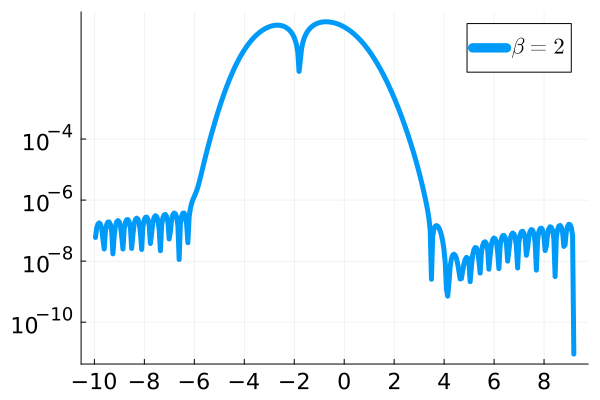

In [19]:
er_cdfro4=err_cdfro4(D1,D2)